# Peter Moss Acute Myeloid & Lymphoblastic Leukemia AI Research Project

## Acute Lymphoblastic Leukemia Detection System 2020

### AllDS2020 CNN

#### Introduction

This notebook is a lower level tutorial for AllDS2020 CNN. AllDS2020 CNN is the classifier that is used in Acute the Lymphoblastic Leukemia Detection System 2020. 

The model used here is based on the [Acute Leukemia Classification Using Convolution Neural Network In Clinical Decision Support System](https://airccj.org/CSCP/vol7/csit77505.pdf "Acute Leukemia Classification Using Convolution Neural Network In Clinical Decision Support System") paper by Thanh.TTP, Giao N. Pham, Jin-Hyeok Park, Kwang-Seok Moon, Suk-Hwan Lee, and Ki-Ryong Kwon, and the data augmentation proposed in  [Leukemia Blood Cell Image Classification Using Convolutional Neural Network](http://www.ijcte.org/vol10/1198-H0012.pdf "Leukemia Blood Cell Image Classification Using Convolutional Neural Network") by T. T. P. Thanh, Caleb Vununu, Sukhrob Atoev, Suk-Hwan Lee, and Ki-Ryong Kwon. The original project was inspired by the [work](https://github.com/AmlResearchProject/AML-ALL-Classifiers/blob/master/Python/_Keras/QuantisedCode/QuantisedCode.ipynb "work") done by [Amita Kapoor](https://www.leukemiaresearchassociation.ai/team/amita-kapoor/profile "Amita Kapoor") and [Taru Jain](https://www.leukemiaresearchassociation.ai/student-program/student/taru-jain "Taru Jain") and my [projects](https://github.com/AMLResearchProject/AML-ALL-Classifiers/tree/master/Python/_Keras/AllCNN "projects") based on their work.

# Getting Started

To get started make sure you completed the steps on the [project home README](https://github.com/AMLResearchProject/ALL-Detection-System-2020 "project home README").

Switch runtime to GPU. (Runtime -> Change runtime type -> GPU)



# Import required packages

The following code block will import all required Python packages.

In [0]:
import cv2, json, pathlib, random, os

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from google.colab import drive
from numpy.random import seed
from scipy import ndimage
from skimage import transform as tm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle

# Mount your Google Drive

Upload the **ALL-Detection-System-2020** directory from your cloned repo to the root of your Google Drive. Use the following commands and follow the provided steps to mount your Google Drive. 

In [2]:
root_dir = "/content/drive/My Drive/ALL-Detection-System-2020/"
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Prepare your data

We will create an augmented dataset based on the [Leukemia Blood Cell Image Classification Using Convolutional Neural Network](http://www.ijcte.org/vol10/1198-H0012.pdf "Leukemia Blood Cell Image Classification Using Convolutional Neural Network") paper by T. T. P. Thanh, Caleb Vununu, Sukhrob Atoev, Suk-Hwan Lee, and Ki-Ryong Kwon. In this case, we will use more rotated images to increase the dataset further.

You will notice the data folder in the Model directory, **Model/Data**, inside you have **Train** & **Test**. 

First take the ten positive and ten negative samples shown below, and place them in the **Model/Data/Test** directory. This will be used by our Oculus Rift application and our testing purposes. 

You can use any data split you like, to ensure you get the same results exactly you may need to use the same test images. Please use CPU for training if you require consistent results, there is currently an issue when using GPU, most likely due to randomness implemented in the GPU software. It is possible to replicate the results here but it may take more than one attempt at training. This is something I will work on for a future update. 

- im006_1.jpg
- im020_1.jpg
- im024_1.jpg
- im026_1.jpg
- im028_1.jpg
- im031_1.jpg
- im035_0.jpg
- im041_0.jpg
- im047_0.jpg
- im053_1.jpg
- im057_1.jpg
- im060_1.jpg
- im063_1.jpg
- im069_0.jpg
- im074_0.jpg
- im088_0.jpg
- im095_0.jpg
- im099_0.jpg
- im101_0.jpg
- im106_0.jpg

Next add the remaining 88 images to the **Model/Data/Train** folder. The test images used will not be augmented, however the validation images will be.

# Setup variables

The following code block will set up the global variables for this notebook.

In [0]:
data = []
labels = []

# Load and print configs

We will use a configuration file to make it easy to manage our settings.

In [4]:
with open(root_dir + 'Model/config.json') as confs:
    confs = json.loads(confs.read())

print(json.dumps(confs, indent=4, sort_keys=True))

{
    "cnn": {
        "api": {
            "port": 1234,
            "server": "192.168.1.34"
        },
        "core": [
            "Train",
            "Server",
            "Client",
            "Classify"
        ],
        "data": {
            "dim": 100,
            "file_type": ".jpg",
            "labels": [
                0,
                1
            ],
            "rotations": 10,
            "seed": 2,
            "split": 0.3,
            "test": "Model/Data/Test",
            "test_data": [
                "im006_1.jpg",
                "im020_1.jpg",
                "im024_1.jpg",
                "im026_1.jpg",
                "im028_1.jpg",
                "im031_1.jpg",
                "im035_0.jpg",
                "im041_0.jpg",
                "im047_0.jpg",
                "im053_1.jpg",
                "im057_1.jpg",
                "im060_1.jpg",
                "im063_1.jpg",
                "im069_0.jpg",
                "im074_0.jpg",
                "

# Set your seeds

Seeds allow us to generate random sequences of numbers in a deterministic way. This helps us to ensure that we can reproduce results consistently.

In [0]:
rseed = confs["cnn"]["data"]["seed"]
dim = confs["cnn"]["data"]["dim"]
            
seed(rseed)
random.seed(rseed)

# Data augmentation functions

Below are the functions used for data augmentation. Each of the methods used are proposed in the [Leukemia Blood Cell Image Classification Using Convolutional Neural Network](http://www.ijcte.org/vol10/1198-H0012.pdf "Leukemia Blood Cell Image Classification Using Convolutional Neural Network") paper by T. T. P. Thanh, Caleb Vununu, Sukhrob Atoev, Suk-Hwan Lee, and Ki-Ryong Kwon.

In [0]:
def grayscale(data):
  """ Creates a grayscale copy. """

  gray = cv2.cvtColor(data, cv2.COLOR_BGR2GRAY)
  return np.dstack([gray, gray, gray]).astype(np.float32)/255.

In [0]:
def equalize_hist(data):
  """ Creates a histogram equalized copy. 

  Credit: Amita Kapoor & Taru Jain
  Exploring novel convolutional network architecture to build a classification 
  system for better assistance in diagonosing Acute Lymphoblastic Leukemia in 
  blood cells.
  https://github.com/AMLResearchProject/ALL-Keras-2019
  """

  img_to_yuv = cv2.cvtColor(data, cv2.COLOR_BGR2YUV)
  img_to_yuv[:, :, 0] = cv2.equalizeHist(img_to_yuv[:, :, 0])
  hist_equalization_result = cv2.cvtColor(img_to_yuv, cv2.COLOR_YUV2BGR)
  return hist_equalization_result.astype(np.float32)/255.

In [0]:
def reflection(data):
  """ Creates horizontal and vertically reflected copies. """

  return cv2.flip(data, 0).astype(np.float32)/255., cv2.flip(data, 1).astype(np.float32)/255.

In [0]:
def gaussian(data):
  """ Creates a gaussian blurred copy. """

  return ndimage.gaussian_filter(data, sigma=5.11).astype(np.float32)/255.

In [0]:
def translate(data):
  """ Creates transformed copy. """

  cols, rows, chs = data.shape

  return cv2.warpAffine(data, np.float32([[1, 0, 84], [0, 1, 56]]), (rows, cols),
                        borderMode=cv2.BORDER_CONSTANT, borderValue=(144, 159, 162)).astype(np.float32)/255.

In [0]:
def rotation(data, label, tdata, tlabels):
  """ Creates rotated copies. """

  cols, rows, chs = data.shape

  for i in range(0, confs["cnn"]["data"]["rotations"]):
      # Seed needs to be set each time randint is called
      random.seed(rseed)
      rand_deg = random.randint(-180, 180)
      matrix = cv2.getRotationMatrix2D((cols/2, rows/2), rand_deg, 0.70)
      rotated = cv2.warpAffine(data, matrix, (rows, cols), borderMode=cv2.BORDER_CONSTANT,
                                borderValue=(144, 159, 162))

      rotated = rotated.astype(np.float32)/255.

      tdata.append(rotated)
      tlabels.append(label)
      
  return tdata, tlabels

In [0]:
def shear(data):
  """ Creates a histogram equalized copy. 
  
  Credit: Amita Kapoor & Taru Jain
  Exploring novel convolutional network architecture to build a classification 
  system for better assistance in diagonosing Acute Lymphoblastic Leukemia in 
  blood cells.
  https://github.com/AMLResearchProject/ALL-Keras-2019
  """

  at = tm.AffineTransform(shear=0.5)
  return tm.warp(data, inverse_map=at)

In [0]:
def resize(path, dim):
  """ Resizes an image to the provided dimensions (dim). """
  
  return cv2.resize(cv2.imread(path), (dim, dim))

In [0]:
def shuffle_c(data, labels, seed):
  """ Shuffles the data and labels. """

  data, labels = shuffle(data, labels, random_state=rseed)

  return data, labels

In [0]:
def convert_data(data):
  """ Converts the training data to a numpy array. """

  data = np.array(data)
  print("Data shape: " + str(data.shape))

  return data

In [0]:
def encode_labels(labels):
  """ One Hot Encodes the labels. """

  encoder = OneHotEncoder(categories='auto')

  labels = np.reshape(labels, (-1, 1))
  labels = encoder.fit_transform(labels).toarray()
  print("Labels shape: " + str(labels.shape))

  return labels

In [0]:
def get_split():
  """ Splits the data and labels creating training and validation datasets. """

  X_train, X_test, y_train, y_test = train_test_split(
      data, labels, test_size=0.255, random_state=rseed)

  print("Training data: " + str(X_train.shape))
  print("Training labels: " + str(y_train.shape))
  print("Validation data: " + str(X_test.shape))
  print("Validation labels: " + str(y_test.shape))

  return X_train, X_test, y_train, y_test

# Sort the data

Here we will sort the data and prepare our augmented dataset. We will use augmentation methods proposed in the 


In [18]:
data_dir = pathlib.Path(
    root_dir + confs["cnn"]["data"]["train_dir"])
data = list(data_dir.glob(
    '*' + confs["cnn"]["data"]["file_type"]))
        
weights_file = root_dir + confs["cnn"]["model"]["weights"]
model_json = root_dir + confs["cnn"]["model"]["model"]

print(data_dir)
print(len(data))

/content/drive/My Drive/ALL-Detection-System-2020/Model/Data/Train
88


In [19]:
count = 0
neg_count = 0
pos_count = 0

augmented_data = []
augmented_labels = []

for rimage in data:
  fpath = str(rimage)
  fname = os.path.basename(rimage)
  label = 0 if "_0" in fname else 1

  image = resize(fpath, dim)

  if image.shape[2] == 1:
      image = np.dstack(
          [image, image, image]) 

  augmented_data.append(image.astype(np.float32)/255.)
  augmented_labels.append(label)

  augmented_data.append(grayscale(image))
  augmented_labels.append(label)

  augmented_data.append(equalize_hist(image))
  augmented_labels.append(label)

  horizontal, vertical = reflection(image)
  augmented_data.append(horizontal)
  augmented_labels.append(label)

  augmented_data.append(vertical)
  augmented_labels.append(label)

  augmented_data.append(gaussian(image))
  augmented_labels.append(label)

  augmented_data.append(translate(image))
  augmented_labels.append(label)

  augmented_data.append(shear(image))
  augmented_labels.append(label)

  data, labels = rotation(image, label, augmented_data, augmented_labels)

  if "_0" in fname:
      neg_count += 9
  else:
      pos_count += 9
  count += 9

data, labels = shuffle_c(data, labels, rseed)
data = convert_data(data)
labels = encode_labels(labels)

print("Raw data: " + str(count))
print("Raw negative data: " + str(neg_count))
print("Raw positive data: " + str(count))
print("Augmented data: " + str(data.shape))
print("Labels: " + str(labels.shape))

X_train, X_test, y_train, y_test = get_split()

Data shape: (1584, 100, 100, 3)
Labels shape: (1584, 2)
Raw data: 792
Raw negative data: 441
Raw positive data: 792
Augmented data: (1584, 100, 100, 3)
Labels: (1584, 2)
Training data: (1180, 100, 100, 3)
Training labels: (1180, 2)
Validation data: (404, 100, 100, 3)
Validation labels: (404, 2)


# Create the network

Replicates the networked outlined in the  Acute Leukemia Classification Using Convolution Neural Network In Clinical Decision Support System paper using Tensorflow 2.0. 

https://airccj.org/CSCP/vol7/csit77505.pdf

In [0]:
def do_network():
  """ Builds the network. 

  Replicates the networked outlined in the  Acute Leukemia Classification 
  Using Convolution Neural Network In Clinical Decision Support System paper
  using Tensorflow 2.0.
  https://airccj.org/CSCP/vol7/csit77505.pdf
  """

  batch_size = confs["cnn"]["train"]["batch"] 

  tf_model = tf.keras.models.Sequential([
      tf.keras.layers.ZeroPadding2D(
          padding=(2, 2), input_shape=X_train.shape[1:]),
      tf.keras.layers.Conv2D(30, (5, 5), strides=1,
                              padding="valid", activation='relu'),
      tf.keras.layers.ZeroPadding2D(padding=(2, 2)),
      tf.keras.layers.Conv2D(30, (5, 5), strides=1,
                              padding="valid", activation='relu'),
      tf.keras.layers.MaxPooling2D(
          pool_size=(2, 2), strides=2, padding='valid'),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(2),
      tf.keras.layers.Activation('softmax')
  ], 
  "AllDS2020_TF_CNN")
  tf_model.summary()
  print("Network initialization complete.")

  return tf_model

In [0]:
def save_model_as_json():
  """ Saves the model to JSON. """

  with open(model_json, "w") as file:
      file.write(tf_model.to_json())
      
  print("Model JSON saved " + model_json)

In [0]:
def save_weights():
  """ Saves the model weights. """
      
  tf_model.save_weights(weights_file)  
  print("Weights saved " + weights_file)

# Train the network

In [0]:
def do_train(tf_model):
  """ Trains the network. """

  val_steps = confs["cnn"]["train"]["val_steps"]
  epochs = confs["cnn"]["train"]["epochs"]

  optimizer = tf.keras.optimizers.Adam(lr=confs["cnn"]["train"]["learning_rate_adam"], 
                                          decay = confs["cnn"]["train"]["decay_adam"])

  tf_model.compile(optimizer=optimizer,
                      loss='binary_crossentropy',
                      metrics=[tf.keras.metrics.BinaryAccuracy(name='acc'),
                              tf.keras.metrics.Precision(name='precision'),
                              tf.keras.metrics.Recall(name='recall'),
                              tf.keras.metrics.AUC(name='auc') ])

  history = tf_model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                                validation_steps=val_steps, epochs=epochs)

  print(history)
  print("") 

  return history

In [24]:
tf_model = do_network()

Model: "AllDS2020_TF_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 104, 104, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 100, 30)      2280      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 104, 104, 30)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 30)      22530     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 30)        0         
_________________________________________________________________
flatten (Flatten)            (None, 75000)             0         
_________________________________________________________________
dense (Dense)                (None, 2)            

In [25]:
history = do_train(tf_model)

Epoch 1/150
37/37 [==============================] - 1s 34ms/step - loss: 0.6917 - acc: 0.5449 - precision: 0.5449 - recall: 0.5449 - auc: 0.5729 - val_loss: 0.6646 - val_acc: 0.5569 - val_precision: 0.5569 - val_recall: 0.5569 - val_auc: 0.7045
Epoch 2/150
37/37 [==============================] - 1s 18ms/step - loss: 0.6284 - acc: 0.6424 - precision: 0.6424 - recall: 0.6424 - auc: 0.7099 - val_loss: 0.5928 - val_acc: 0.7252 - val_precision: 0.7252 - val_recall: 0.7252 - val_auc: 0.7898
Epoch 3/150
37/37 [==============================] - 1s 17ms/step - loss: 0.5529 - acc: 0.7602 - precision: 0.7602 - recall: 0.7602 - auc: 0.8189 - val_loss: 0.5536 - val_acc: 0.7450 - val_precision: 0.7450 - val_recall: 0.7450 - val_auc: 0.8049
Epoch 4/150
37/37 [==============================] - 1s 17ms/step - loss: 0.4925 - acc: 0.7619 - precision: 0.7619 - recall: 0.7619 - auc: 0.8510 - val_loss: 0.4422 - val_acc: 0.7723 - val_precision: 0.7723 - val_recall: 0.7723 - val_auc: 0.8948
Epoch 5/150
37/3

In [26]:
save_model_as_json()

Model JSON saved /content/drive/My Drive/ALL-Detection-System-2020/Model/model.json


In [27]:
save_weights()

Weights saved /content/drive/My Drive/ALL-Detection-System-2020/Model/weights.h5


# Evaluate the model

In [0]:
def do_predictions():
  """ Makes predictions on the train & test sets. """

  train_preds = tf_model.predict(X_train)
  test_preds = tf_model.predict(X_test)

  print("Training predictions: " + str(train_preds))
  print("Training predictions shape: " + str(train_preds.shape))
  print("")
  print("Testing predictions: " + str(test_preds))
  print("Testing predictions shape: " + str(test_preds.shape))
  print("")

  return train_preds, test_preds

In [0]:
def visualize_metrics():
  """ Visualize the metrics. """

  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.ylim((0, 1))
  plt.legend(['Train', 'Validate'], loc='upper left')
  plt.savefig(root_dir + 'Model/Plots/Accuracy.png')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validate'], loc='upper left')
  plt.savefig(root_dir + 'Model/Plots/Loss.png')
  plt.show()

  plt.plot(history.history['auc'])
  plt.plot(history.history['val_auc'])
  plt.title('Model AUC')
  plt.ylabel('AUC')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validate'], loc='upper left')
  plt.savefig(root_dir + 'Model/Plots/AUC.png')
  plt.show()

  plt.plot(history.history['precision'])
  plt.plot(history.history['val_precision'])
  plt.title('Model Precision')
  plt.ylabel('Precision')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validate'], loc='upper left')
  plt.savefig(root_dir + 'Model/Plots/Precision.png')
  plt.show()

  plt.plot(history.history['recall'])
  plt.plot(history.history['val_recall'])
  plt.title('Model Recall')
  plt.ylabel('Recall')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validate'], loc='upper left')
  plt.savefig(root_dir + 'Model/Plots/Recall.png')
  plt.show()

In [0]:
def confusion_matrix_c(train_preds, test_preds):
  """ Prints/displays the confusion matrix. """

  matrix = confusion_matrix(y_test.argmax(axis=1), 
                            test_preds.argmax(axis=1))

  print("Confusion Matrix: " + str(matrix))
  print("")

  plt.imshow(matrix, cmap=plt.cm.Blues)
  plt.xlabel("Predicted labels")
  plt.ylabel("True labels")
  plt.xticks([], [])
  plt.yticks([], [])
  plt.title('Confusion matrix ')
  plt.colorbar()
  plt.savefig(root_dir + 'Model/Plots/Confusion-Matrix.png')
  plt.show()

  return matrix

In [0]:
def figures_of_merit(matrix):
  """ Calculates/prints the figures of merit. 

  https://homes.di.unimi.it/scotti/all/results.php
  """

  test_len = len(X_test)

  TP = matrix[1][1]
  TN = matrix[0][0]
  FP = matrix[0][1]
  FN = matrix[1][0]

  TPP = (TP * 100)/test_len
  FPP = (FP * 100)/test_len
  FNP = (FN * 100)/test_len
  TNP = (TN * 100)/test_len

  specificity = TN/(TN+FP) 

  misc = FP + FN        
  miscp = (misc * 100)/test_len 

  print("True Positives: " + str(TP) + "(" + str(TPP) + "%)")
  print("False Positives: " + str(FP) + "(" + str(FPP) + "%)")
  print("True Negatives: " + str(TN) + "(" + str(TNP) + "%)")
  print("False Negatives: " + str(FN) + "(" + str(FNP) + "%)")

  print("Specificity: " + str(specificity))
  print("Misclassification: " + str(misc) + "(" + str(miscp) + "%)")

In [0]:
def do_evaluate():
  """ Evaluates the model """

  train_preds, test_preds = do_predictions()

  metrics = tf_model.evaluate(X_test, y_test, verbose=0)        
  for name, value in zip(tf_model.metrics_names, metrics):
      print("Metrics: " + name + " " + str(value))
  print()

  visualize_metrics()        
  matrix = confusion_matrix_c(train_preds, test_preds)
  figures_of_merit(matrix)

Training predictions: [[4.5429658e-08 1.0000000e+00]
 [9.9966812e-01 3.3190424e-04]
 [9.9989235e-01 1.0762364e-04]
 ...
 [9.9996078e-01 3.9209172e-05]
 [3.9263859e-02 9.6073616e-01]
 [4.2276907e-34 1.0000000e+00]]
Training predictions shape: (1180, 2)

Testing predictions: [[1.64164332e-21 1.00000000e+00]
 [9.99918342e-01 8.16889660e-05]
 [1.13144845e-08 1.00000000e+00]
 [9.92075324e-01 7.92461820e-03]
 [9.94516075e-01 5.48386527e-03]
 [5.40748537e-01 4.59251523e-01]
 [8.19067623e-08 9.99999881e-01]
 [4.20557272e-27 1.00000000e+00]
 [3.83874431e-05 9.99961615e-01]
 [8.19067623e-08 9.99999881e-01]
 [8.14363648e-06 9.99991894e-01]
 [9.99999285e-01 7.35762796e-07]
 [9.99775469e-01 2.24505813e-04]
 [9.99918342e-01 8.16889660e-05]
 [9.94531751e-01 5.46824560e-03]
 [9.97141123e-01 2.85894191e-03]
 [6.96022511e-01 3.03977549e-01]
 [9.99114692e-01 8.85271118e-04]
 [5.24609204e-05 9.99947548e-01]
 [9.36351866e-02 9.06364858e-01]
 [9.98626232e-01 1.37382688e-03]
 [9.99859571e-01 1.40394681e-04]


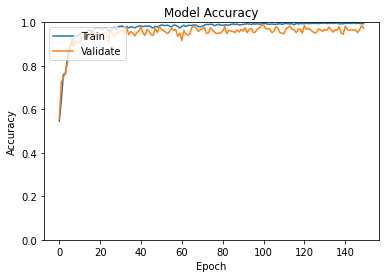

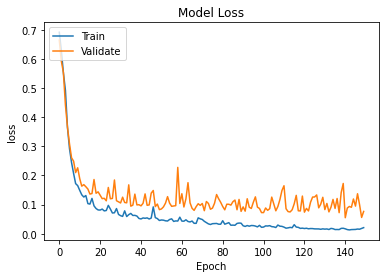

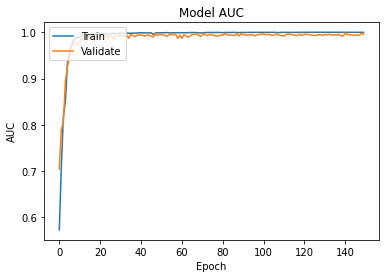

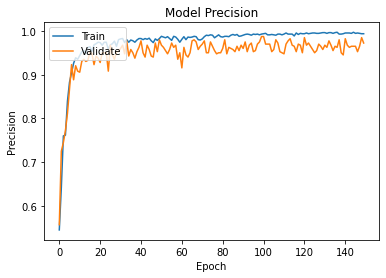

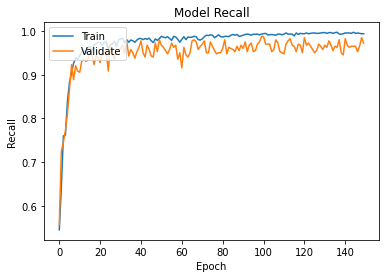

Confusion Matrix: [[225   0]
 [ 11 168]]



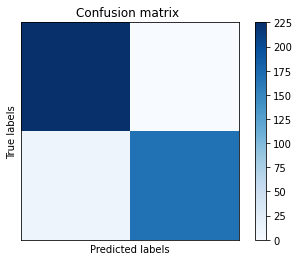

True Positives: 168(41.584158415841586%)
False Positives: 0(0.0%)
True Negatives: 225(55.693069306930695%)
False Negatives: 11(2.722772277227723%)
Specificity: 1.0
Misclassification: 11(2.722772277227723%)


In [33]:
do_evaluate()